In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

unicef = pd.read_csv('stud_math.csv')

# Цели и задачи проекта: отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

Чтобы определиться с параметрами будущей модели, требуется провести разведывательный анализ данных и составить отчёт по его результатам. 

In [2]:
display(unicef.head(10))
unicef.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Итак, а нашем наборе данных 395 строк, однако лишь первые три колонки не содержат пропусков данных. 17 столбцов содержат строковые данные, 13 столбцов - целые и дробные числа.

Визуальный анализ также показывает, что набор содержит столбец "studytime, granular", не описываемый в тексте задания. Удалим его, чтобы не засорять матрицу корреляций

In [3]:
unicef = unicef.drop(['studytime, granular'], axis="columns")

Так как у нас есть несколько столбцов, в который лишь два возможных значения (yes и no), удобно превратить их в числительные (1 и 0). Такой подход позволит выяснить, существует ли корреляция итоговой оценки (score) от образовательных поддержек, посещений детского сада, наличия интернета, романтических отношений и прочих "бинарных" переменных.

In [4]:
def numerizer(x):
    if x == 'yes':
        x = 1
    elif x == 'no':
        x = 0
    else:
        x = 0.5
    return float(x)

Вот какой логикой я руководствуюсь:
- в нашем наборе 29 строк, многие из них 'yes' или 'no', остальные - неизвестные (None или NaN)
- в целом данные довольно чистые
- если перед анализом вычистить все строки, в которых нам неизвестно "да или нет" хотя бы в одном столбце, мы потеряем много ценных данных, что снизит точность анализа
- я принимаю, что в случае, если мы не знаем, "да или нет", считаем вероятность "да" в 50%, то есть значение 0,5
- это не вполне корректно, так как в некоторых случаях соотношение "да"/"нет" будет совсем другим. Правильнее было бы задать его в качестве еще одной переменной
- однако так как таких данных в каждой конкретной колонке немного (не более 20-30 записей, как мы видим из функции .info), то и на точность коэффициента корреляции это маленькое допущение повлияет незначительно.

In [5]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=unicef,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

Задаем функцию для построения коробок с усами.

# Очищаем столбец School

In [6]:
pd.DataFrame(unicef.school.value_counts())

,school
GP,349
MS,46


Итак, перед нами данные учеников всего из 2 школ. Они закодированы аббревиатурами GP и MS. Можно было бы сделать предположение, что это типы медицинских школ (аббревиатуры типичны для General Practice и Medical School), но у нас для этого нет достаточных оснований (тем более, не факт, что в школах этого профиля преподают математику). 

Не будем делать предположений - пока нам достаточно, что этот столбец абсолютно чист. Построим график распределения учеников по школам.

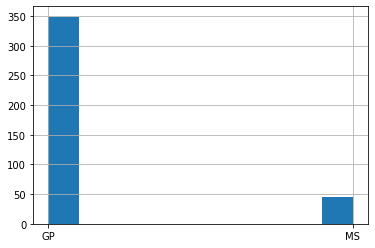

In [7]:
unicef.school.hist()

# Очищаем столбец sex

In [8]:
pd.DataFrame(unicef.sex.value_counts())

,sex
F,208
M,187


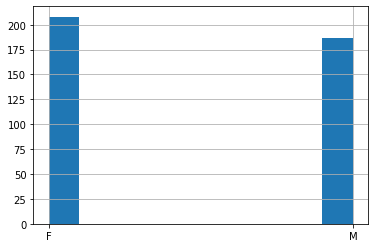

In [9]:
unicef.sex.hist()

Выяснили, что (как в советской песне) "на 10 девчонок по статистике 9 ребят". Также выяснили, что столбец чист: в нем не содержится пустых строк или лишних строковых объектов.

Так как здесь тоже есть всего два значения, можно преобразовать их в числа (девочка = 0, мальчик = 1). Это позволит оценить корреляцию между полом учащегося и успеваемостью по математике (отрицательная будет означать, что девочки лучше мальчиков, положительная наоборот). Господи, на какой тонкий лед я встал.

In [10]:
unicef.sex = unicef.sex.apply((lambda x: 0 if x == 'F' else 1))

In [11]:
pd.DataFrame(unicef.sex.value_counts())

,sex
0,208
1,187


# Cтолбец Age

In [12]:
pd.DataFrame(unicef.age.value_counts())

,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1


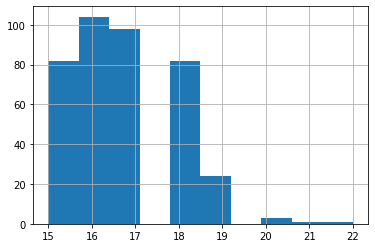

In [13]:
unicef.age.hist()

Тут я был неприятно удивлен, что за дырок налепил мне в графике Питон. Поэтому решил построить гистограмму иным способом (заодно продемонстрирую, что я умею делать красиво, с подписями осей).

Text(0.5, 0, 'Возраст')

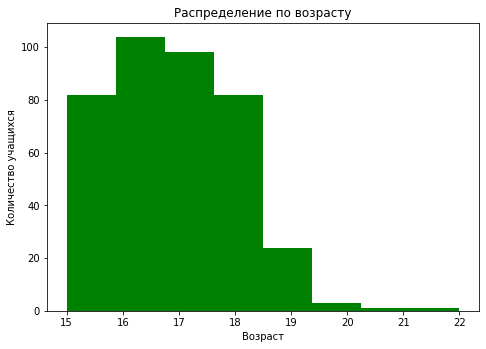

In [14]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(unicef['age'], bins=8, color='green')
axes.set_title('Распределение по возрасту')
axes.set_ylabel('Количество учащихся')
axes.set_xlabel('Возраст')

Да, визуально это похоже на нормальное распределение. Но вот остаются эти пятеро высоковозрастных детин 20-22 лет: я б их убрал (слишком мало по ним данным), но давайте посмотрим, какого мнения наука.

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


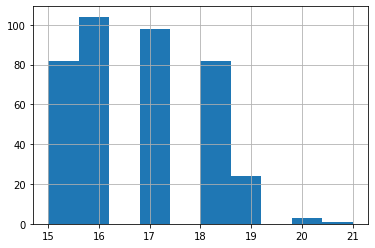

In [15]:
median = unicef.age.median()
IQR = unicef.age.quantile(0.75) - unicef.age.quantile(0.25)
perc25 = unicef.age.quantile(0.25)
perc75 = unicef.age.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
unicef.age.loc[unicef.age.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist()

Наука говорит, что 21-летка еще туда-сюда, а вот 22-летнего прочь. В данном случае, я все же предпочту удалить как 22-летнего, так и 21-летнего ученика, руководствуясь здравым смыслом: 20-летние еще близки к довольно масштабной группе 19-летних (там может быть разница 1-2 дня), а вот 2 ученика 21-22 явно лишние. Прощайте.

In [16]:
unicef = unicef.loc[unicef.age <= 20]

# Столбец Address

In [17]:
pd.DataFrame(unicef.address.value_counts())

,address
U,294
R,82


Итак, у нас 294 городских и 82 сельских учащихся. Гистограмму построить можно, но, на мой взгляд, не нужно. 
Вот только сразу видно, что не сходится: у нас должно оставаться 393 учащихся, значит, остальные значения пусты. 

И здесь меня настигает экзистенциальный вопрос: выбросить ли их из датасета? Нужно ли выбрасывать из набора данные только потому, что они неполны? Я принимаю решение этого не делать: 393 записи - и без того немного для анализа.

# Столбец Famsize

In [18]:
pd.DataFrame(unicef.famsize.value_counts())

,famsize
GT3,259
LE3,107


Итак, 259 учащихся имеют 3 человек в семье и более, 107 - менее трех, по остальным нет данных. Как и ранее, я не удаляю "пустые" данные ради сохранения массива.

# Столбец Pstatus

In [19]:
pd.DataFrame(unicef.Pstatus.value_counts())

,Pstatus
T,312
A,36


У 312 учащихся родители живут вместе, у 36 раздельно, по остальным нет данных. Лишних значений также нет.

# Столбец Medu

In [20]:
pd.DataFrame(unicef.Medu.value_counts())

,Medu
4.0,131
2.0,102
3.0,96
1.0,58
0.0,3


C:\Users\dhanb\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\dhanb\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Уровень образования матери')

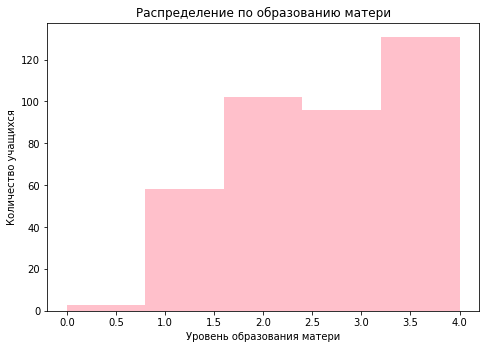

In [21]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(unicef['Medu'], bins=5, color='pink')
axes.set_title('Распределение по образованию матери')
axes.set_ylabel('Количество учащихся')
axes.set_xlabel('Уровень образования матери')

# Вывод 1
Так как уровни образования ранжированы от низшего ("Нет образования") к высшему, мы можем сделать первый вывод: чем выше уровень образования матери, тем выше вероятность, что ребенок попадет в рассматриваемые школы. Тот факт, что "2" немного выше "3", не должен смущать нас: и то и другое относится к среднему образованию (2 классов относятся к двойке, 11 - к тройке).

# Столбец Fedu

In [22]:
pd.DataFrame(unicef.Fedu.value_counts())

,Fedu
2.0,106
3.0,96
4.0,88
1.0,76
0.0,2
40.0,1


Видим очевидный выброс: значение 40.0. Его необходимо удалить (опечатка, которая может быть как 4, так и 0). Пустые значения я не удаляю, чтобы не сократить размер датафрейма драматически.

In [23]:
unicef = unicef.loc[unicef.Fedu != 40.0]

C:\Users\dhanb\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\dhanb\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Уровень образования отца')

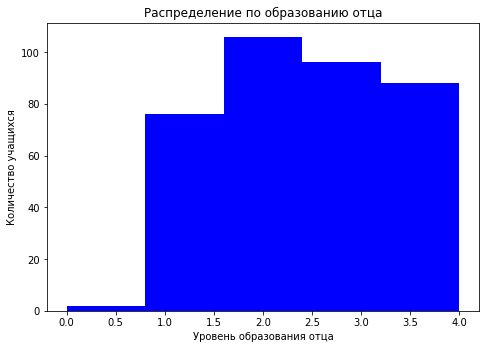

In [24]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(unicef['Fedu'], bins=5, color='blue')
axes.set_title('Распределение по образованию отца')
axes.set_ylabel('Количество учащихся')
axes.set_xlabel('Уровень образования отца')

# Вывод 1 (продолжение)
Высшее образование у отца ребенка не является предпосылкой для повышения вероятности поступления в эти две школы. Проще сказать, что уровень образования отца должен быть "хоть каким-нибудь".

# Столбец Mjob

In [25]:
pd.DataFrame(unicef.Mjob.value_counts())

,Mjob
other,132
services,96
at_home,58
teacher,55
health,32


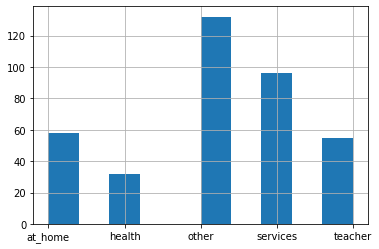

In [26]:
unicef.Mjob.hist()

Итак, среди матерей есть домохозяйки (58), учителя (55), медсестры/врачи (32), работницы сферы услуг (96), но больше всего матерей относятся к рубрике Other ("неизвестно кто"). Все пустые значения точно так же можно отнести к этому самому загадочному 'other'. Суммарно это треть от всех записей, что делает информативность этой колонки крайне незначительной. Рука тянется удалить ее, но бог с ним, попозже проанализирую.

# Столбец Fjob

In [27]:
pd.DataFrame(unicef.Fjob.value_counts())

,Fjob
other,195
services,101
teacher,29
at_home,16
health,15


Даже без гистограммы видно, что нет данных по половине отцов (other либо пропуски). При этом из выбранных составителями профессий лишь по 3-4% приходится на врачей и безработных, лишь 6% - на учителей. По сути, большие объемы только у "сферы услуг" (которая ни о чем не говорит, так как содержит слишком много отраслей и специальностей)
Эту колонку считаю неинформативной, выбрасываю.

In [28]:
unicef = unicef.drop(['Fjob'], axis="columns")

# Столбец Reason

In [29]:
pd.DataFrame(unicef.reason.value_counts())

,reason
course,136
home,104
reputation,102
other,33


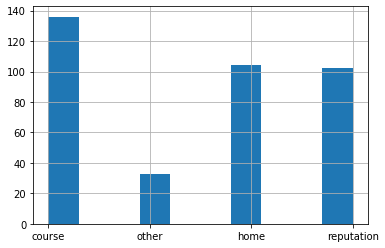

In [30]:
unicef.reason.hist()

Итак, образовательная программа, близость к дому и репутация действительно являются наиболее значимыми факторами выбора школы. Лишних значений нет. 

Вообще, по-честному, здесь (как и в Mjob) пустые значения стоит привести к виду 'other'. Но я понятия не имею, какие выводы это поможет сделать, поэтому не буду заниматься пижонством.

# Столбец guardian

In [31]:
pd.DataFrame(unicef.guardian.value_counts())

,guardian
mother,249
father,85
other,28


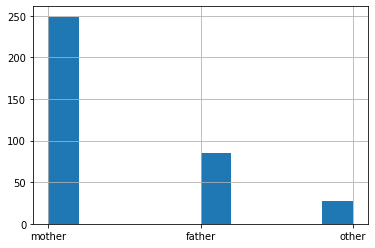

In [32]:
unicef.guardian.hist()

Вспоминая столбец Pstatus, можно осознать бессмысленность этого столбца: напомню, у более чем 300 человек родители живут вместе. Это значит, что столбец guardian - это в большинстве случаев просто случайный из родителей, живущих в паре (чаще это по каким-то причинам мать, но на жизненные обстоятельства это не влияет - возможно, именно матери чаще занимаются вопросами оформления детей в школу). Таким образом, этот столбец вообще нельзя считать информативным.
Убиваю.

In [33]:
unicef = unicef.drop(['guardian'], axis="columns")

# Столбец traveltime

In [34]:
pd.DataFrame(unicef.traveltime.value_counts())

,traveltime
1.0,240
2.0,96
3.0,21
4.0,7


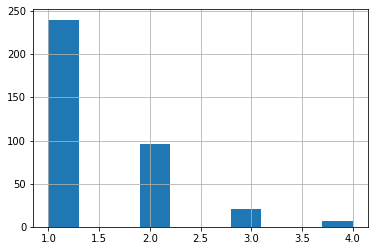

In [35]:
unicef.traveltime.hist()

Распределение очень четко показывает: чем ближе живет ученик к школе, тем больше шансов у него в ней учиться. Большинство учеников тратит на дорогу менее 15 минут, и лишь 7 человек более часа. Так как таких значений 7 (в курсе обучения мы выкидывали только в случае, если их менее 5), то оставим их в выборке.

# Столбец studytime 

In [36]:
pd.DataFrame(unicef.studytime.value_counts())

,studytime
2.0,194
1.0,101
3.0,63
4.0,27


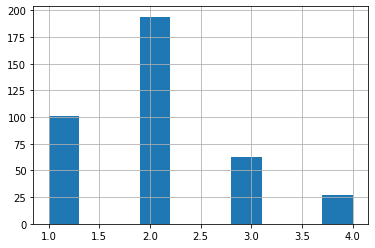

In [37]:
unicef.studytime.hist()

Время, затрачиваемое на обучение, распределено нормально: большинство учащихся тратят от 2 до 5 часов.
Вопрос ментору: насколько вообще корректно оценивать распределение с неравномерными интервалами?
Например, 2 = от 2 до 5 часов (интервал 3 часа), 3 = от 5 до 10 часов (интервал 5 часов).
И как преобразовать данные, если мы не знаем, как распределены ответы внутри каждого интервала (условно, кто учится 6 часов, а кто 9)?

# Столбец failures

In [38]:
pd.DataFrame(unicef.failures.value_counts())

,failures
0.0,292
1.0,49
2.0,16
3.0,13


Почти три четверти учащихся не имело "неучебных неудач" (знать бы еще что это)

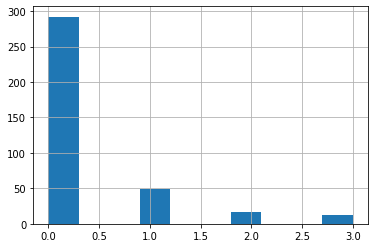

In [39]:
unicef.failures.hist()

# Столбец schoolsup

In [40]:
pd.DataFrame(unicef.schoolsup.value_counts())

,schoolsup
no,333
yes,51


Так как я считаю коэффициенты корреляции более надежным источником, нежели визуальный анализ графиков, преобразую этот столбец в численные значения

In [41]:
unicef.schoolsup = unicef.schoolsup.apply(numerizer)

# Столбец famsup

In [42]:
pd.DataFrame(unicef.famsup.value_counts())

,famsup
yes,218
no,135


Итак, в отличие от школьного допобразования (которое мало у кого было), большинство обучающихся получали учебную поддержку от семьи

In [43]:
unicef.famsup = unicef.famsup.apply(numerizer)

# Столбец paid

In [44]:
pd.DataFrame(unicef.paid.value_counts())

,paid
no,197
yes,155


155 учеников посещали дополнительные платные курсы по математике.

In [45]:
unicef.paid = unicef.paid.apply(numerizer)

# Столбец activities

In [46]:
pd.DataFrame(unicef.activities.value_counts())

,activities
yes,194
no,184


Около половины учеников посещали дополнительные внеучебные занятия

In [47]:
unicef.activities = unicef.activities.apply(numerizer)

# Столбец nursery

In [48]:
pd.DataFrame(unicef.nursery.value_counts())

,nursery
yes,299
no,77


Подавляющее большинство (299 человек) посещали детский сад

In [49]:
unicef.nursery = unicef.nursery.apply(numerizer)

# Столбец higher

In [50]:
pd.DataFrame(unicef.higher.value_counts())

,higher
yes,355
no,18


У подавляющего большинства есть амбиции к получению высшего образования. Таких детей гораздо больше, чем тех, чья мать или отец имеют высшее образование. Это можно объяснить либо веянием времени, либо влиянием школы.

In [51]:
unicef.higher = unicef.higher.apply(numerizer)

# Столбец internet

In [52]:
pd.DataFrame(unicef.internet.value_counts())

,internet
yes,303
no,55


Удивительно, но у 55 человек (это более 10% выборки) нет интернета

In [53]:
unicef.internet = unicef.internet.apply(numerizer)

# Столбец romantic 

In [54]:
pd.DataFrame(unicef.romantic.value_counts())

,romantic
no,238
yes,123


У подавляющего большинства нет отношений. Извините, стало интересно, отвлекусь.

In [55]:
def get_boxplot_love(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='age',
                data=unicef,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

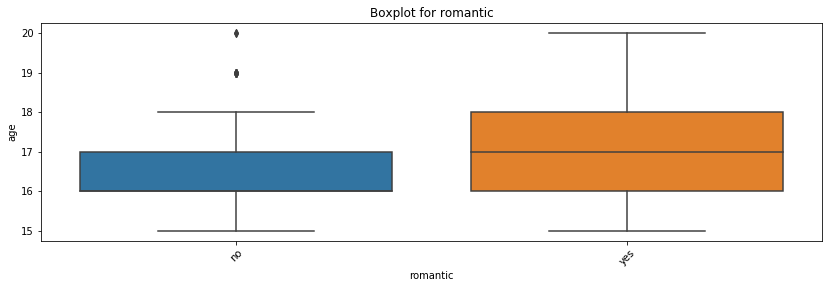

In [56]:
for col in ['romantic']:
    get_boxplot_love(col)

Ну да, так и есть. Среди ребят "в отношениях" больше тех, кто постарше. А кого нет пары в 19 или 20 - выброс )

Но лишних значений тут нет, преобразую все в нули и единицы.

In [57]:
unicef.romantic = unicef.romantic.apply(numerizer)

# Столбец famrel 

In [58]:
pd.DataFrame(unicef.famrel.value_counts())

,famrel
4.0,182
5.0,96
3.0,62
2.0,17
1.0,7
-1.0,1


Видим очевидный выброс: значение -1 не предусмотрено шкалой. Выкидываем именно его.
Ну конечно же, можно было бы заменить на NaN. Но проще выкинуть.

In [59]:
unicef = unicef.loc[unicef.famrel != -1.0]

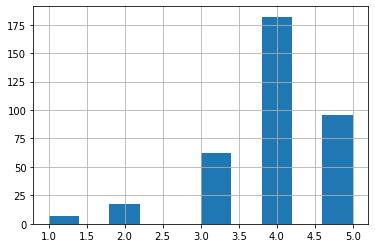

In [60]:
unicef.famrel.hist()

Имеет вид нормального распределения

# Столбец freetime 

In [61]:
pd.DataFrame(unicef.freetime.value_counts())

,freetime
3.0,153
4.0,111
2.0,61
5.0,37
1.0,18


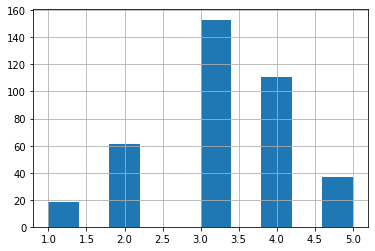

In [62]:
unicef.freetime.hist()

Наконец, красивое классическое нормальное распределение. Никаких аномальных значений.

# Столбец goout 

In [63]:
pd.DataFrame(unicef.goout.value_counts())

,goout
3.0,126
2.0,99
4.0,84
5.0,51
1.0,23


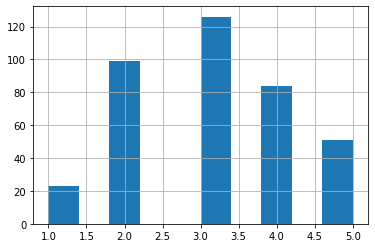

In [64]:
unicef.goout.hist()

Та же история: прогулки с друзьями имеют нормальное распределение

# Столбец health 

In [65]:
pd.DataFrame(unicef.health.value_counts())

,health
5.0,137
3.0,88
4.0,62
1.0,46
2.0,43


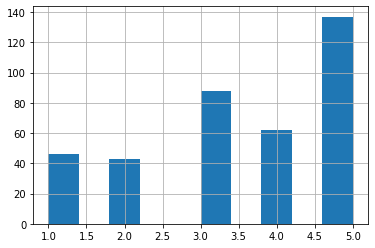

In [66]:
unicef.health.hist()

Очевидно, ребята любят прихвастнуть

# Столбец absences 

In [67]:
pd.DataFrame(unicef.absences.value_counts())

,absences
0.0,111
2.0,60
4.0,52
6.0,31
8.0,21
10.0,17
12.0,12
14.0,11
3.0,7
16.0,6


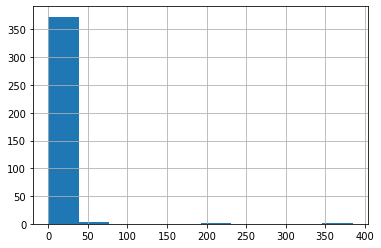

In [68]:
unicef.absences.hist()

Именно этот столбец содержит наиболее серьезные выбросы. Рассчитаем референтные значения

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


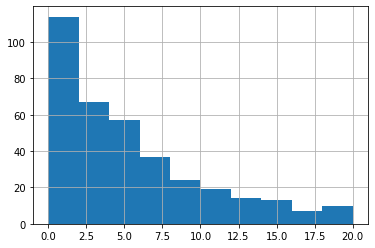

In [69]:
median = unicef.absences.median()
IQR = unicef.absences.quantile(0.75) - unicef.absences.quantile(0.25)
perc25 = unicef.absences.quantile(0.25)
perc75 = unicef.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
unicef.absences.loc[unicef.absences.between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist()

Итак, из-за того что почти треть школьников не пропускала занятия вообще, граница 25-го персентиля остается на уровне нуля, а 75-го персентиля - лишь на уровне 8. Очевидно, что распределение не имеет вид нормального, и - вот здесь поправьте меня - я не знаю, применима ли вообще эта логика.

Но другой у меня нет, поэтому выкидываем все, что выше 20 пропущенных занятий (это 17 значений от 21 до 385, большинство из которых встречается по 1 разу)

In [70]:
unicef = unicef.loc[unicef.absences <= 20]

In [71]:
unicef.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 394
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      362 non-null    object 
 1   sex         362 non-null    int64  
 2   age         362 non-null    int64  
 3   address     347 non-null    object 
 4   famsize     340 non-null    object 
 5   Pstatus     326 non-null    object 
 6   Medu        359 non-null    float64
 7   Fedu        339 non-null    float64
 8   Mjob        346 non-null    object 
 9   reason      345 non-null    object 
 10  traveltime  334 non-null    float64
 11  studytime   357 non-null    float64
 12  failures    343 non-null    float64
 13  schoolsup   362 non-null    float64
 14  famsup      362 non-null    float64
 15  paid        362 non-null    float64
 16  activities  362 non-null    float64
 17  nursery     362 non-null    float64
 18  higher      362 non-null    float64
 19  internet    362 non-null    f

# Столбец score 

Это самый важный столбец, результирующий. Именно влияние на него мы оцениваем.
В нем, как мы видим из последнего запроса, не 362, а 357 ненулевых значений. 
Нулевые нам нужно удалить.

In [72]:
pd.DataFrame(unicef.score.value_counts())

,score
50.0,53
55.0,42
0.0,36
75.0,31
65.0,30
60.0,28
70.0,27
40.0,24
45.0,23
80.0,16


In [73]:
unicef = unicef.loc[unicef.score <= 100.0]

Так мы избавились от нулевых значений (но не от значения score = 0.0). Проверим:

In [74]:
unicef.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 0 to 394
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      357 non-null    object 
 1   sex         357 non-null    int64  
 2   age         357 non-null    int64  
 3   address     343 non-null    object 
 4   famsize     335 non-null    object 
 5   Pstatus     321 non-null    object 
 6   Medu        354 non-null    float64
 7   Fedu        334 non-null    float64
 8   Mjob        341 non-null    object 
 9   reason      340 non-null    object 
 10  traveltime  329 non-null    float64
 11  studytime   352 non-null    float64
 12  failures    338 non-null    float64
 13  schoolsup   357 non-null    float64
 14  famsup      357 non-null    float64
 15  paid        357 non-null    float64
 16  activities  357 non-null    float64
 17  nursery     357 non-null    float64
 18  higher      357 non-null    float64
 19  internet    357 non-null    f

Да, осталось 357 значений всего, и 357 значений с оценками. Приступаем к анализу

Построим детальную гистограмму. Мы видим, что количество баллов кратно 5, а оценки могут включать оба крайних значения: "0" и "100". Таким образом, у нас есть 21 возможная оценка. Исходя из этого строим гистограмму распределения по выборке.

Text(0.5, 0, 'Балл по математике')

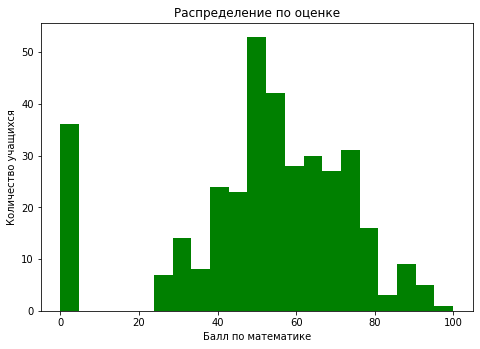

In [75]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(unicef['score'], bins=21, color='green')
axes.set_title('Распределение по оценке')
axes.set_ylabel('Количество учащихся')
axes.set_xlabel('Балл по математике')

Гистограмма наглядно показывает разрыв между значениями "0 баллов" и "25 баллов". Вполне вероятно, это означает, что балл ниже 25 является непроходным и "обнуляет" результат. Либо может быть следствием психологических особенностей обучающихся, которые бросают тест, если понимают, что не решают и четверти задач.

В любом случае, мы не можем считать позицию "0" выбросом, так как исследуем именно риски неуспеваемости. Более того, любопытно было бы поработать именно с выборкой студентов, получивших 0 баллов - однако так как в ней лишь 36 наблюдений, вряд ли это поможет нам выбрать параметры для построения модели.

In [76]:
print(unicef.score.median())
print(unicef.score.quantile(0.25))
print(unicef.score.quantile(0.75))

55.0
45.0
70.0


Итак, медианное значение баллов по математике - 55 баллов, квартили находятся на уровне 45 и 70 баллов. Лишь один ученик оказался способным решить все задания и набрать 100 баллов.
Иными словами, "среднестатистический" ученик решает лишь больше половины заданий - вероятно, математика не является профильным предметом (подтверждается моя догадка о школах с медицинским уклоном). Либо уровень преподавания в школах не соответствует принятой учебной программе.

# Корреляционный анализ количественных переменных

In [77]:
unicef.corr()

,sex,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
sex,1.000000,-0.085350,0.090698,0.038696,0.059815,-0.300007,0.006222,-0.108021,-0.126392,-0.107405,0.114001,0.009417,-0.182396,0.046811,-0.122337,0.033704,0.202120,0.056821,0.141509,0.024569,0.118938
age,-0.085350,1.000000,-0.163420,-0.142476,0.100926,0.031080,0.106941,-0.243108,-0.128847,-0.026349,-0.056198,-0.079076,-0.109582,-0.107805,0.107862,0.028957,0.010185,0.108384,-0.036760,0.141774,-0.152639
Medu,0.090698,-0.163420,1.000000,0.630992,-0.192122,0.083939,-0.234819,-0.028827,0.182664,0.136725,0.088509,0.160770,0.144156,0.206069,0.002579,-0.012128,0.044842,0.053995,-0.054299,0.068237,0.208224
Fedu,0.038696,-0.142476,0.630992,1.000000,-0.151626,-0.007002,-0.264568,0.056801,0.188325,0.064881,0.081481,0.110847,0.179475,0.107700,0.013106,-0.020644,0.001678,0.050800,0.010154,-0.013388,0.107148
traveltime,0.059815,0.100926,-0.192122,-0.151626,1.000000,-0.113631,0.093481,-0.012596,-0.027740,-0.034399,-0.012940,-0.053007,-0.150305,-0.097260,0.028251,-0.048554,-0.001014,0.030959,-0.002727,-0.043553,-0.080700
studytime,-0.300007,0.031080,0.083939,-0.007002,-0.113631,1.000000,-0.148135,0.004633,0.106436,0.199784,0.095387,0.067351,0.152042,0.092498,0.050486,0.023892,-0.133536,-0.031774,-0.096497,-0.063092,0.106976
failures,0.006222,0.106941,-0.234819,-0.264568,0.093481,-0.148135,1.000000,0.047594,-0.044154,-0.177478,-0.024445,-0.096988,-0.227152,-0.058472,0.076442,-0.004515,0.071691,0.071293,0.125761,0.045522,-0.329088
schoolsup,-0.108021,-0.243108,-0.028827,0.056801,-0.012596,0.004633,0.047594,1.000000,0.066898,-0.041667,0.028904,0.039300,0.064621,-0.012083,-0.014152,-0.021286,-0.065230,-0.026752,-0.057728,0.041609,-0.092320
famsup,-0.126392,-0.128847,0.182664,0.188325,-0.027740,0.106436,-0.044154,0.066898,1.000000,0.273756,-0.034285,0.048069,0.068822,0.131426,0.005033,-0.027538,0.013607,-0.024460,-0.001284,0.047102,-0.028338
paid,-0.107405,-0.026349,0.136725,0.064881,-0.034399,0.199784,-0.177478,-0.041667,0.273756,1.000000,0.010521,0.085158,0.147145,0.192962,0.062409,0.003384,-0.073222,-0.003272,-0.108215,-0.066005,0.105891


Для того, чтобы выбрать факторы для включения в модель, анализируем последний столбец: корреляцию количественных переменных с переменной score. В модель будут вклчены переменные с наибольшими модулями коэффициента корреляции (что означает наиболее сильную прямую или обратную связь). 

Предлагаю включать в модель переменные с коэффициентом коррелляции, по модулю большим или равным 0.1. Вот что к ним относится.

# Выводы по корреляционному анализу

1. Наиболее важным фактором, коррелирующим с успеваемостью по математике, является количество внеучебных неудач. Оно обратно коррелирует с количеством набранных баллов (больше неудач - ниже балл). Этот фактор является ключевым фактором риска и требует более детального изучения! Отрицательная корреляция на уровне около 33%.
2. Второй по силе фактор - уровень образования матери, что приводит нас к выводу, что именно ожидания матерей сильнее стимулируют учеников к обцению математике. Этическое значение данного фактора оставим при себе, примем его как факт, полученный на выборке. Положительная корреляция на уровне более 20%.
3. Третьим по силе фактором является возраст ученика, при чем корреляция обратная: чем младше ученики, тем выше их успеваемость по предмету. Можно предположить, что это связано с более легкой программой у более молодых учеников. Однако для полной оценки данного фактора необходимо ознакомиться с организацией учебного процесса в конкретных школах (также на успеваемость может влиять, например, более сильный преподаватель в младших классах или усиленная специализация с уклоном в другие науки для более старших учеников). Отрицательная корреляция более 15%.

*** За наиболее сильными факторами следуют (корреляция на уровне 12% по модулю):
4. Стремление получить высшее образование (оценки выше, если такие паны есть)
5. Время, проводимое с друзьями (чем его меньше, тем успешнее ученик в математике).
6. Наличие романтических отношений (немного успешнее те, у кого их нет). 
7. Также выяснилось, что пол ученика коррелирует с его успеваемостью по математике: в выборке мальчики показали в среднем лучший результат. Тем не менее, стоит помнить, что корреляция не означает причинной-следственной связи.

*** Наиболее слабыми факторами с корреляцией не менее 0,1 являются:
8. Уровень образования отца, который влияет в меньшей степени, чем образование матери (однако, мы помним, что и отцов с высшим образованием в нашей выборке было меньше, чем матерей).
9. Время, посвящаемое учебе, что неудивительно (удивительно лишь, что связь не сильна).
10. Дополнительные платные занятия по математике (которые также демонстрируют странно слабую эффективность).

Таким образом, на этом шаге мы выводим из модели такие факторы, как:
- семейные отношения,
- семейная образовательная поддержка,
- дополнительная школьная образовательная поддержка,
- время в пути до школы,
- дополнительные внеучебные занятия,
- свободное время,
- состояние здоровья,
- количество пропущенных занятий (удивительно), 
- посещение детского сада,
- наличие интернета.

Все эти факторы рекомендую не включать в модель.

# Анализ влияния номинативных переменных

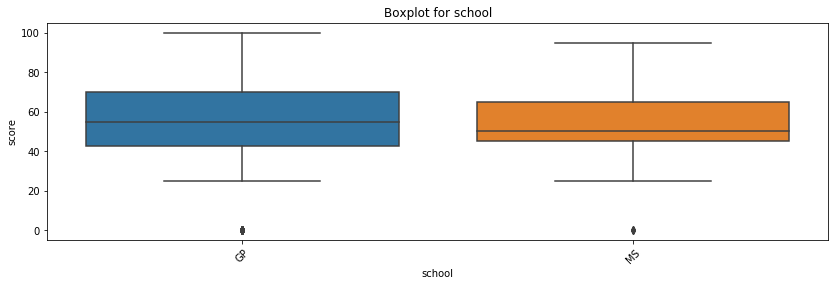

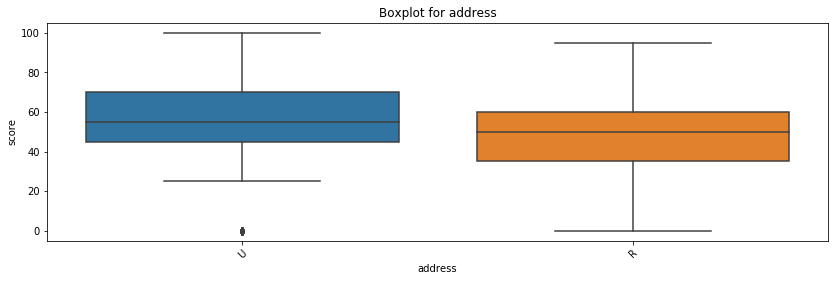

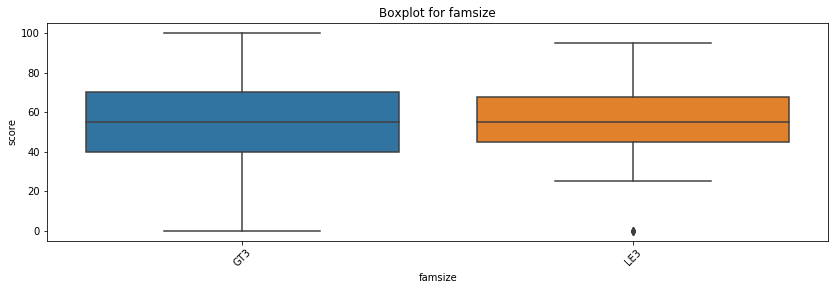

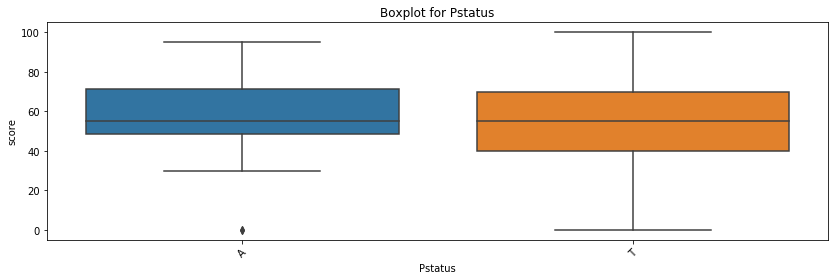

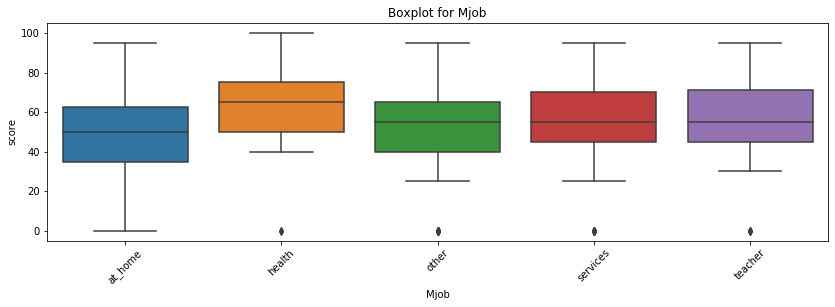

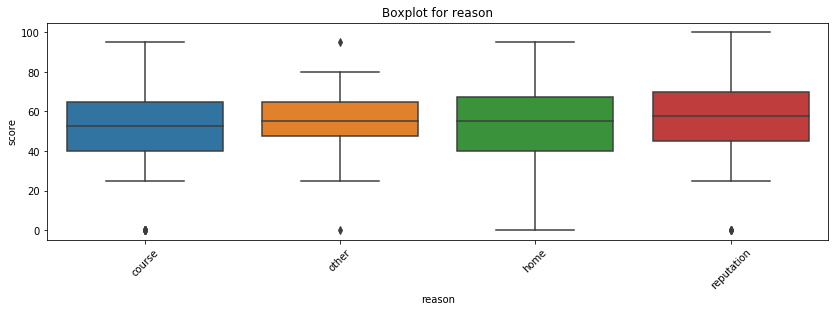

In [78]:
for col in ['school', 'address', 'famsize', 'Pstatus', 'Mjob', 'reason']:
    get_boxplot(col)

Невооруженным взглядом видно, что:
1. Медианное значение балла по математике в школе MS ниже, чем чем в GP. Также у нее и меньше разброс показаний (возможно, связано с тем, что выборка по этой школе меньше),
2. Городские ученики показывают более высокие результаты по математике (например, для них нулевое значение является выбросом)
3. В больших семьях такое же медианное значение успеваемости - однако больше разброс оценок.
4. Дети матерей-врачей успевают в математике немного лучше, чем их товарищи по парте (странная закономерность, которая снова приводит к мысли, что школы, наверное, медицинские и матери-медики просто сильнее давят на детей).

Далее попробуем оценить статистическую значимые отличия, провернув фокус из примера с какао (я правда не знаю про поправку Бонферони, объясните при разборе, а?)

In [79]:
def get_stat_dif(column):
    cols = unicef.loc[:, column]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(unicef.loc[unicef.loc[:, column] == comb[0], 'score'],
                     unicef.loc[unicef.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [80]:
for col in ['school', 'address', 'famsize', 'Pstatus', 'Mjob', 'reason']:
    get_stat_dif(col)

Просчет колонок с данными типа object показал, что среди них нет существенно влияющих на оценку по математике. Таким образом, мы не считаем факторами риска следующие переменные:
- школу,
- проживание в городе или за городом,
- размер семьи,
- совместное или раздельное проживание родителей,
- профессию матери (как ранее мы отмели профессию отца),
- причину выбора школы.

# Финальные выводы

Данные, с которыми мы работаем, довольно чистые: в них присутствуют пропуски, однако крайне мало ошибок ручного ввода. Существенные выбросы среди факторных столбцов содержатся только в столбце "absenses" (вероятно, это не ошибки ввода, а настоящие длительные пропуски занятий, связанные с отъездами, прогулами, состоянием здоровья и проч.)

В риск-модель успеваемости по математике необходимо включить следующие переменные:
1. Количество внеучебных неудач (фактор риска),
2. Уровень образования матери,
3. Возраст ученика (риск растет с возрастом).

Рекомендую также включить факторы более слабого влияния:
4. Желание получить высшее образование,
5. Время, проводимое с друзьями (фактор риска),
6. Романтические отношения (фактор риска),
7. Пол.

Также возможно включение дополнительных факторов таких как:
8. Уровень образования отца,
9. Дополнительные платные занятия по математике,
10. Время, посвящаемое учебе.
Решение о включении или невключении данных факторов оставляю на усмотрение команды проекта, в зависимости от имеющихся ресурсов и требуемого уровня точности предсказания рисков.

***
Особое мнение.
Учет некоторых факторов (например, пола или наличия романтических отношений) может иметь негативные этические последствия: например, приводить к формированию стереотипов ("девочки хуже разбираются в математике", "запретим им встречаться, пусть лучше учатся" и так далее). Прошу команду проекта продумать механизмы, защищающие обучающихся и их личную жизнь от посягательств со стороны администрации и преподавательского состава. Выбранные факторы призваны составить точную предиктивную модель и помочь ребятам, но не приводить к предрассудкам, которые сами по себе могут влиять на успеваемость учеников.